## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn.utils import shuffle

import warnings 
warnings.filterwarnings('ignore')

data = pd.read_csv('/datasets/Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Всего 10000 строк.
Признак "Tenure" имеет Null-значения.

In [2]:
print(data['Tenure'].describe())
print("Какой процент выборки составляют NULL-значения в признаке Tenure {:.2%}".format(len(data[pd.isna(data['Tenure'])])/len(data)))

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64
Какой процент выборки составляют NULL-значения в признаке Tenure 9.09%


в принципе, всего 9% составляют NULL-значения в признаке Tenure, можно удалить их, можно заменить медианным значением, я выбираю удалить

In [12]:
data = data.dropna()

In [13]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
RowNumber          9091 non-null int64
CustomerId         9091 non-null int64
Surname            9091 non-null object
CreditScore        9091 non-null int64
Geography          9091 non-null object
Gender             9091 non-null object
Age                9091 non-null int64
Tenure             9091 non-null float64
Balance            9091 non-null float64
NumOfProducts      9091 non-null int64
HasCrCard          9091 non-null int64
IsActiveMember     9091 non-null int64
EstimatedSalary    9091 non-null float64
Exited             9091 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.0+ MB
None


обработали Null-значения в Tenure

In [14]:
print(data.sample(5))

      RowNumber  CustomerId Surname  CreditScore Geography  Gender  Age  \
8864       8865    15599124  Miller          832    France  Female   29   
6093       6094    15742126    Chiu          712   Germany    Male   38   
5964       5965    15802220  Ikenna          599     Spain    Male   35   
7908       7909    15579287   Rossi          581    France    Male   35   
6428       6429    15577423  Mosley          627   Germany  Female   39   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
8864     5.0       0.00              2          1               0   
6093     7.0  132767.66              2          1               1   
5964     6.0  137102.65              1          0               0   
7908     4.0       0.00              2          0               1   
6428     5.0  124586.93              1          1               0   

      EstimatedSalary  Exited  
8864        178779.52       0  
6093         59115.77       0  
5964         76870.81       0  
7908  

In [15]:
print(data['Geography'].value_counts())
print(data['Age'].describe())
print(data['NumOfProducts'].describe())

France     4550
Germany    2293
Spain      2248
Name: Geography, dtype: int64
count    9091.000000
mean       38.949181
std        10.555581
min        18.000000
25%        32.000000
50%        37.000000
75%        44.000000
max        92.000000
Name: Age, dtype: float64
count    9091.000000
mean        1.530195
std         0.581003
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: NumOfProducts, dtype: float64


Нам представлены данные о клиентах банка (которые уже ушли из банка и которые еще пользуются банковскими продуктами). Возраст клиентов от 18 до 92 лет.
Эти клиенты территориально проживают во Франции, Германии, Испании. Средний возраст клиента 38 лет.
Клиенты пользуются (пользовались) от 1 до 4 банковских продуктов, в среднем каждый клиент пользуется (пользовался) 1 банковским продуктом.

## Исследование задачи

Для того, чтобы определить уйдет ли клиент из банка или нет, нам не нужны признаки:
<ul>
 <li>RowNumber — индекс строки в данных </li>
 <li>CustomerId — уникальный идентификатор клиента </li>
 <li>Surname — фамилия</li>
</ul>
Удалим их

In [16]:
data = data.drop(['RowNumber','CustomerId','Surname'], axis=1)

Так как выборка содержит категориальные признаки - Geography и Gender, то их нужно перекодировать в числовые данные.
Будем использовать технику прямого кодирования, укажем drop_first=True (чтобы уменьшить фиктивный столбец)

In [17]:
data = pd.get_dummies(data, drop_first=True)
print(data.sample(5))

      CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
8029          671   50     8.0       0.00              1          0   
1602          571   42     4.0  108825.34              3          1   
1781          793   36     0.0       0.00              1          0   
1078          677   41     8.0  146720.98              2          1   
8775          807   37    10.0  130110.45              2          0   

      IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
8029               1          2560.11       0                  0   
1602               0         55558.51       1                  0   
1781               0        148993.47       0                  0   
1078               1          4195.84       0                  1   
8775               1        172097.95       0                  1   

      Geography_Spain  Gender_Male  
8029                1            1  
1602                0            0  
1781                1            0  
1078            

Выделим признаки и целевой признак.

Разделим выборку на обучающую, валидационную, тестовую в отношении 60%,20%,20% соответственно

In [18]:
target = data['Exited']
features = data.drop('Exited', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=12345,stratify=target)
features_valid, features_test,target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=12345,stratify=target_valid)

print("Обучающая выборка = {:.1%}".format(len(features_train)/len(data)))
print("Валидационная выборка = {:.1%}".format(len(features_valid)/len(data)))
print("Тестовая выборка = {:.1%}".format(len(features_test)/len(data)))

Обучающая выборка = 60.0%
Валидационная выборка = 20.0%
Тестовая выборка = 20.0%


Проведем маштабирование численных признаков отдельно обучающей, валидационной, тестовой выборки, которые имеют сильный разброс:
<ul>
 <li>CreditScore — кредитный рейтинг </li>
 <li>Age — возраст</li>
 <li>Tenure — сколько лет человек является клиентом банка</li>
 <li>Balance — баланс на счёте</li>   
 <li>NumOfProducts — количество продуктов банка, используемых клиентом</li>    
 <li>EstimatedSalary — предполагаемая зарплата</li>    
</ul>

Признаки:
<ul>
 <li>Gender — пол </li>
 <li>HasCrCard — наличие кредитной карты</li>
 <li>IsActiveMember — активность клиента</li>   
</ul>

маштабировать не будем, потому что их значения составляют только 0 и 1.

In [19]:
numeric = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']

In [20]:
scaler = StandardScaler()

scaler.fit(features_train[numeric]) 

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.sample(3))

      CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
2247    -0.574195  0.202723 -1.053112  1.000158      -0.910943          0   
4361     1.363178  0.874386  1.382122  0.102374      -0.910943          1   
831      0.602811  0.202723 -0.009440 -1.222967      -0.910943          0   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
2247               1         0.219337                  1                0   
4361               0         0.435729                  1                0   
831                1         0.996795                  0                1   

      Gender_Male  
2247            0  
4361            0  
831             0  


## Борьба с дисбалансом

### Оценка несбалансированной модели

Проверим основные параметры на несбалансированной модели

Напишем функцию, чтобы проще было работать

In [21]:
def metrics(model, features, target):
    score1 = model.score(features, target)
    predict = model.predict(features) 
    f_1 = f1_score(target,predict)
    precision_score1 = precision_score(target,predict)
    recall_score1 = recall_score(target,predict)

    probabilities_valid = model.predict_proba(features)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc = roc_auc_score(target, probabilities_one_valid)
    
    return score1,f_1,auc,precision_score1,recall_score1

In [22]:
def print_metrics(array):
    print("score = {:.4}".format(array[0]))
    print("f1 = {:.4}".format(array[1]))
    print("auc = {:.4}".format(array[2]))
    print("precision = {:.4}".format(array[3]))
    print("recall = {:.4}".format(array[4]))  

#### Логистическая регрессия

In [23]:
model_LogisticRegression = LogisticRegression(solver='liblinear')
model_LogisticRegression.fit(features_train, target_train)


print('Валидационная выборка')
print_metrics(metrics(model_LogisticRegression,features_valid, target_valid))

print('')

print('Тестовая выборка')
print_metrics(metrics(model_LogisticRegression,features_test, target_test))

Валидационная выборка
score = 0.8152
f1 = 0.3307
auc = 0.7893
precision = 0.6336
recall = 0.2237

Тестовая выборка
score = 0.8158
f1 = 0.352
auc = 0.7744
precision = 0.6233
recall = 0.2453


In [25]:
predict = model_LogisticRegression.predict(features_valid)
print(classification_report(target_valid, predict))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1447
           1       0.63      0.22      0.33       371

    accuracy                           0.82      1818
   macro avg       0.73      0.60      0.61      1818
weighted avg       0.79      0.82      0.78      1818



#### Дерево решений

In [26]:
decision_tree_valid = {}
decision_tree_train = {}
best_result_decision_tree = 0
best_depth_decision_tree = 0

for depth in range(1,21):   
    model_DecisionTreeClassifier = DecisionTreeClassifier(max_depth=depth, min_samples_split=5, min_samples_leaf=5,random_state=12345)

    model_DecisionTreeClassifier.fit(features_train, target_train)

    result = metrics(model_DecisionTreeClassifier,features_valid, target_valid)[1]

    decision_tree_valid[depth] = result
    decision_tree_train[depth] = metrics(model_DecisionTreeClassifier,features_train, target_train)[1]
    if result > best_result_decision_tree:
        best_result_decision_tree = result
        best_depth_decision_tree = depth

        
print('best_result_f1 = ', best_result_decision_tree, ', ', 'best_depth = ', best_depth_decision_tree) 


best_result_f1 =  0.5882352941176471 ,  best_depth =  7


In [27]:
model_DecisionTreeClassifier = DecisionTreeClassifier(max_depth=7, min_samples_split=5, min_samples_leaf=5,random_state=12345)
model_DecisionTreeClassifier.fit(features_train, target_train)


print('Валидационная выборка')
print_metrics(metrics(model_DecisionTreeClassifier,features_valid, target_valid))

print('')

print('Тестовая выборка')
print_metrics(metrics(model_DecisionTreeClassifier,features_test, target_test))

Валидационная выборка
score = 0.8614
f1 = 0.5882
auc = 0.8416
precision = 0.7469
recall = 0.4852

Тестовая выборка
score = 0.8543
f1 = 0.5516
auc = 0.8262
precision = 0.7409
recall = 0.4394


In [28]:
predict = model_DecisionTreeClassifier.predict(features_valid)
print(classification_report(target_valid, predict))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1447
           1       0.75      0.49      0.59       371

    accuracy                           0.86      1818
   macro avg       0.81      0.72      0.75      1818
weighted avg       0.85      0.86      0.85      1818



Видим, что качество 1-го класса - среднее: recall = 0.49, а f1-score= 0.59

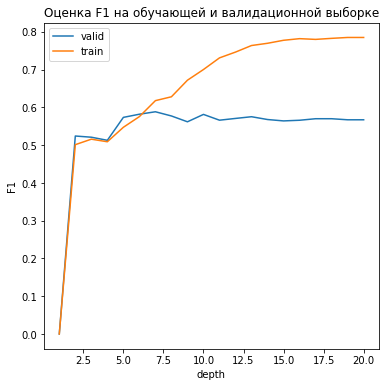

In [29]:
plt.figure(figsize=(6,6))
plt.title("Оценка F1 на обучающей и валидационной выборке")
plt.xlabel("depth")
plt.ylabel("F1")

dataframe = pd.DataFrame(index=decision_tree_valid.keys(), data=decision_tree_valid.values(),columns=['f1'])
dataframe.reset_index(inplace=True)
dataframe.columns=['depth','f1']
plt.plot(dataframe['depth'],dataframe['f1'], label="valid") ;

dataframe2 = pd.DataFrame(index=decision_tree_train.keys(), data=decision_tree_train.values(),columns=['f1'])
dataframe2.reset_index(inplace=True)
dataframe2.columns=['depth','f1']
plt.plot(dataframe2['depth'],dataframe2['f1'], label="train");
plt.legend();

Мы видим, что на valid-выборке наибольшая метрика F1 достигается при глубине дерева = 7, далее  F1 начинает падать, на train-выборке F1 растет с увиличением глубины дерева

#### Случайный лес

In [30]:
decision_tree_valid = []
best_result_random_forest = 0
best_depth_random_forest = 0
best_est_random_forest = 0

for depth in range(2,40,2): 
    for est in range(2,100,5):  
        model_RandomForestClassifier = RandomForestClassifier(n_estimators=est, max_depth=depth, min_samples_split=5, min_samples_leaf=5,random_state=12345)

        model_RandomForestClassifier.fit(features_train, target_train)

        result = metrics(model_RandomForestClassifier,features_valid, target_valid)[1]

        decision_tree_valid.append([depth, est, result])
       
        if result > best_result_random_forest:
            best_result_random_forest = result
            best_depth_random_forest = depth
            best_est_random_forest = est
            
print('best_result_f1 = ', best_result_random_forest, ', ', 'best_depth = ', best_depth_random_forest, ', ', 'best_est = ', best_est_random_forest)   

best_result_f1 =  0.6075533661740558 ,  best_depth =  14 ,  best_est =  17


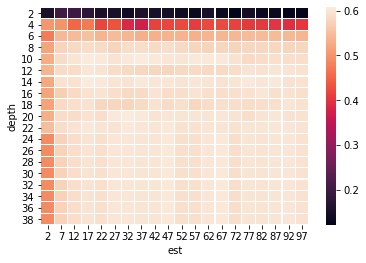

In [31]:
df_decision_tree = pd.DataFrame(data=decision_tree_valid)

df_decision_tree.columns=['depth','est','f1']

df_decision_tree_pivot = df_decision_tree.pivot('depth','est','f1')

sns.heatmap(df_decision_tree_pivot,fmt="d",
            linewidths=.1);

Мы видим, что на valid-выборке наибольшая метрика F1 достигается при глубине дерева (max_depth) = 14  и количестве деревьев (n_estimators) = 17

In [34]:
model_RandomForestClassifier = RandomForestClassifier(n_estimators=17, max_depth=14, min_samples_split=5, min_samples_leaf=5,random_state=12345)
model_RandomForestClassifier.fit(features_train, target_train)

print('Валидационная выборка')
print_metrics(metrics(model_RandomForestClassifier,features_valid, target_valid))

print('')

print('Тестовая выборка')
print_metrics(metrics(model_RandomForestClassifier,features_test, target_test))

Валидационная выборка
score = 0.8685
f1 = 0.6076
auc = 0.8699
precision = 0.7773
recall = 0.4987

Тестовая выборка
score = 0.8549
f1 = 0.5629
auc = 0.8411
precision = 0.7296
recall = 0.4582


In [35]:
predict = model_RandomForestClassifier.predict(features_valid)
print(classification_report(target_valid, predict))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1447
           1       0.78      0.50      0.61       371

    accuracy                           0.87      1818
   macro avg       0.83      0.73      0.76      1818
weighted avg       0.86      0.87      0.86      1818



auc = 0.8699


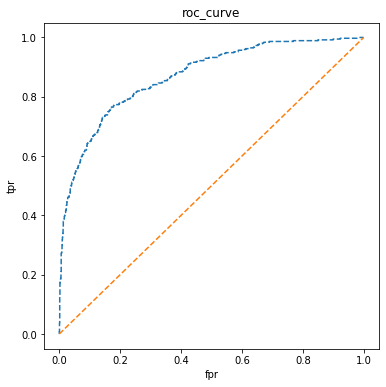

In [36]:
model_RandomForestClassifier = RandomForestClassifier(n_estimators=17, max_depth=14, min_samples_split=5, min_samples_leaf=5,random_state=12345)

model_RandomForestClassifier.fit(features_train, target_train)

probabilities_valid = model_RandomForestClassifier.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure(figsize=(6,6))
plt.title("roc_curve")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.plot(fpr, tpr, linestyle='--');
plt.plot([0,1], [0,1], linestyle='--');
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc = {:.4}".format(auc_roc))

Мы видим достаточно большие значения метрики AUC-ROC. 

Достаточно большие значения метрик при n_estimators=17, max_depth=14:
Валидационная выборка:

<ul>
 <li>score = 0.8685 </li>
 <li>f1 = 0.6076</li>
 <li>auc = 0.8699</li>
 <li>precision = 0.7773</li>   
 <li>recall = 0.4987</li>     
</ul>

занесем информацию в таблицу:

In [37]:
df = pd.DataFrame(data={'L_R_valid':metrics(model_LogisticRegression,features_valid, target_valid),
                        'L_R_test':metrics(model_LogisticRegression,features_test, target_test),
                        'D_T_valid':metrics(model_DecisionTreeClassifier,features_valid, target_valid),
                        'D_T_test':metrics(model_DecisionTreeClassifier,features_test, target_test),
                        'R_F_valid':metrics(model_RandomForestClassifier,features_valid, target_valid),
                        'R_F_test':metrics(model_RandomForestClassifier,features_test, target_test)},
                  index=['score','f1','auc','precision','recall'])


df

,L_R_valid,L_R_test,D_T_valid,D_T_test,R_F_valid,R_F_test
score,0.815182,0.815833,0.861386,0.854316,0.868537,0.854865
f1,0.330677,0.352031,0.588235,0.551607,0.607553,0.562914
auc,0.789301,0.774359,0.841588,0.826179,0.869913,0.841145
precision,0.633588,0.623288,0.746888,0.740909,0.777311,0.729614
recall,0.22372,0.245283,0.485175,0.439353,0.498652,0.458221


Выбираем Модель случайного леса. Она дает самые высокие значения метрик среди всех моделей как на валидационной, так и на тестовой выборке

### Перебалансировка данных / изменение выборки

0    0.796062
1    0.203938
Name: Exited, dtype: float64


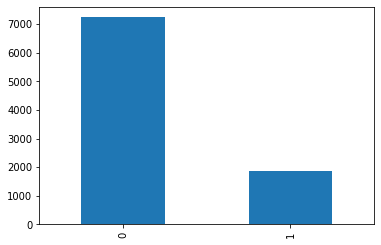

In [38]:
print(data['Exited'].value_counts(normalize=True))
data['Exited'].value_counts().plot(kind='bar');

Мы видим, что значения несбалансированны, преобладает нулевой класс, класс 1 составляет всего 20%.
Попробуем изменить выборку. Класс 1 мы попробуем увеличить, а класс 0 попробуем уменьшить.
Посмотрим, как изменятся метрики

#### Увеличение выборки

In [39]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [40]:
#установим минамальную метрику F1, которую хотим достичь
f1_best = 0.59
repeat_massiv = {}
model = RandomForestClassifier(n_estimators=17, max_depth=14, min_samples_split=5, min_samples_leaf=5,random_state=12345)
for repeat in range(1,10):
    features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)
    #обучаем на train
    model.fit(features_upsampled,target_upsampled)
    #предсказываем на valid
    predict = model.predict(features_valid)
    #подбираем на валидационных данных
    f1_r = metrics(model,features_valid, target_valid)[1]
    #заносим значения в массив для графика
    repeat_massiv[repeat] = f1_r
    
    if f1_r>f1_best:
        print('')
        print("Количество повторений: {}".format(repeat))
        f1_best = f1_r
        print("Процент класса 0: {:.2%}".format(len(target_upsampled[target_upsampled == 0])/len(target_upsampled)))
        print("Процент класса 1: {:.2%}".format(len(target_upsampled[target_upsampled == 1])/len(target_upsampled)))
        print_metrics(metrics(model,features_valid, target_valid))


Количество повторений: 2
Процент класса 0: 66.13%
Процент класса 1: 33.87%
score = 0.8504
f1 = 0.6201
auc = 0.8682
precision = 0.6435
recall = 0.5984

Количество повторений: 3
Процент класса 0: 56.55%
Процент класса 1: 43.45%
score = 0.8465
f1 = 0.6362
auc = 0.8673
precision = 0.6162
recall = 0.6577

Количество повторений: 5
Процент класса 0: 43.85%
Процент класса 1: 56.15%
score = 0.8311
f1 = 0.6401
auc = 0.8687
precision = 0.5664
recall = 0.7358


получили наилучшую метрику F1=0.6401 при 5 повторениях

In [41]:
model_RandomForestClassifier_up = RandomForestClassifier(n_estimators=17, max_depth=14, min_samples_split=5, min_samples_leaf=5,random_state=12345)
features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

model_RandomForestClassifier_up.fit(features_upsampled,target_upsampled)

print('Валидационная выборка')
print_metrics(metrics(model_RandomForestClassifier_up,features_valid, target_valid))

print('')

print('Тестовая выборка')
print_metrics(metrics(model_RandomForestClassifier_up,features_test, target_test))

Валидационная выборка
score = 0.8311
f1 = 0.6401
auc = 0.8687
precision = 0.5664
recall = 0.7358

Тестовая выборка
score = 0.812
f1 = 0.587
auc = 0.842
precision = 0.5317
recall = 0.655


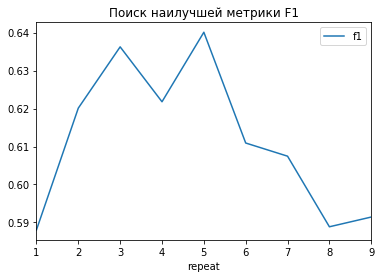

In [42]:
dataframe = pd.DataFrame(index=repeat_massiv.keys(), data=repeat_massiv.values(),columns=['f1'])
dataframe.reset_index(inplace=True)
dataframe.columns=['repeat','f1']
dataframe.plot(x='repeat',y='f1', title='Поиск наилучшей метрики F1'); 

Мы видим по графику, что метрика F1 после пяти повторений класса 1 начинает уменьшаться. 

Пять повторений класса 1 позволяет достичь сбалансированности классов и высоких значений метрик:
<ul>
 <li>Процент класса 0: 43.85% </li>
 <li>Процент класса 1: 56.15% </li>
 <li>Валидационная выборка: score = 0.8311,f1 = 0.6401,auc = 0.8687,precision = 0.5664,recall = 0.7358</li>
 <li>Тестовая выборка: score = 0.812,f1 = 0.587,auc = 0.842,precision = 0.5317,recall = 0.655</li>
</ul>


Попробуем пересчитать гипер параметры в связи с увеличением класса 1
Посмотрим, что изменится

In [43]:
best_result_random_forest = 0
best_depth_random_forest = 0
best_est_random_forest = 0

features_upsampled, target_upsampled = upsample(features_train, target_train, 5)

for depth in range(2,40,2): #глубина
    for est in range(2,100,5): #количество деревьв  
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, min_samples_split=5, min_samples_leaf=5,random_state=12345)
        #обучаем на upsampled данных
        model.fit(features_upsampled, target_upsampled)
        #предсказываем на valid
        predict = model.predict(features_valid)
        #подбираем на валидационных данных
        result = metrics(model,features_valid, target_valid)[1]
   
        if result > best_result_random_forest:
            best_result_random_forest = result
            best_depth_random_forest = depth
            best_est_random_forest = est
            best_model_random_forest = model
            
print('best_result_f1 = ', best_result_random_forest, ', ', 'best_depth = ', best_depth_random_forest, ', ', 'best_est = ', best_est_random_forest)   


best_result_f1 =  0.6474820143884892 ,  best_depth =  20 ,  best_est =  82


параметры изменились best_depth =  20 (вместо 14) ,  best_est =  82 (вместо 17). Но F1 и auc при таких параметрах и upsampled-выборке больше, даже удалость достичь F1 на тестовой выборке >0,59

In [44]:
model_RandomForestClassifier_up = RandomForestClassifier(n_estimators=82, max_depth=20, min_samples_split=5, min_samples_leaf=5,random_state=12345)
features_upsampled, target_upsampled = upsample(features_train, target_train, 5)
model_RandomForestClassifier_up.fit(features_upsampled, target_upsampled)

#проверяем на валидационной выборке
print('Валидационная выборка')
print_metrics(metrics(model_RandomForestClassifier_up,features_valid, target_valid))

print('')
#проверяем на тестовой выборке
print('Тестовая выборка')
print_metrics(metrics(model_RandomForestClassifier_up,features_test, target_test))

Валидационная выборка
score = 0.8383
f1 = 0.6475
auc = 0.874
precision = 0.5832
recall = 0.7278

Тестовая выборка
score = 0.8257
f1 = 0.6033
auc = 0.8482
precision = 0.5631
recall = 0.6496


#### Уменьшение выборки

In [45]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled


установим минимальную метрику F1, которую хотим достичь

In [46]:
f1_best = 0.59
model = RandomForestClassifier(n_estimators=17, max_depth=14, min_samples_split=5, min_samples_leaf=5,random_state=12345)
for fraction in np.arange(0.02,0.6,0.02):
    features_downsampled, target_downsampled = downsample(features_train, target_train, fraction)
    #обучаем на downsampled данных
    model.fit(features_downsampled, target_downsampled)
    #предсказываем на valid
    predict = model.predict(features_valid)
    
    #подбираем на валидационных данных
    f1_r = metrics(model,features_valid, target_valid)[1]
    
    if f1_r>f1_best:
        print('')
        print("fraction: {:.2}".format(fraction))
        f1_best = f1_r
        print("Процент класса 0: {:.2%}".format(len(target_downsampled[target_downsampled == 0])/len(target_downsampled)))
        print("Процент класса 1: {:.2%}".format(len(target_downsampled[target_downsampled == 1])/len(target_downsampled)))
        print_metrics(metrics(model,features_valid, target_valid))


fraction: 0.26
Процент класса 0: 50.38%
Процент класса 1: 49.62%
score = 0.7959
f1 = 0.6082
auc = 0.8671
precision = 0.5
recall = 0.7763

fraction: 0.28
Процент класса 0: 52.23%
Процент класса 1: 47.77%
score = 0.8014
f1 = 0.6106
auc = 0.8716
precision = 0.509
recall = 0.7628

fraction: 0.32
Процент класса 0: 55.54%
Процент класса 1: 44.46%
score = 0.8102
f1 = 0.6171
auc = 0.8729
precision = 0.5245
recall = 0.7493

fraction: 0.34
Процент класса 0: 57.03%
Процент класса 1: 42.97%
score = 0.8218
f1 = 0.6241
auc = 0.869
precision = 0.5479
recall = 0.7251

fraction: 0.36
Процент класса 0: 58.43%
Процент класса 1: 41.57%
score = 0.8333
f1 = 0.638
auc = 0.8781
precision = 0.573
recall = 0.7197

fraction: 0.54
Процент класса 0: 67.83%
Процент класса 1: 32.17%
score = 0.8614
f1 = 0.639
auc = 0.8716
precision = 0.682
recall = 0.6011


Уменьшение класса 0 позволяет достичь сбалансированности классов и высоких значений метрик:

    Процент класса 0: 67.83%
    Процент класса 1: 32.17%
    Валидационная выборка: score = 0.8614,f1 = 0.639,auc = 0.8716,precision = 0.682,recall = 0.6011

Попробуем пересчитать гипер параметры в связи с уменьшением класса 0, 

Посмотрим, что изменится


In [47]:
best_result_random_forest = 0
best_depth_random_forest = 0
best_est_random_forest = 0

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.54)

for depth in range(2,40,2): #глубина
    for est in range(2,100,5): #количество деревьв  
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, min_samples_split=5, min_samples_leaf=5,random_state=12345)
        #обучаем на downsampled данных
        model.fit(features_downsampled, target_downsampled)
        #подбираем на валидационных данных
        result = metrics(model,features_valid, target_valid)[1]
        
        if result > best_result_random_forest:
            best_result_random_forest = result
            best_depth_random_forest = depth
            best_est_random_forest = est
            best_model_random_forest = model
            
print('best_result_f1 = ', best_result_random_forest, ', ', 'best_depth = ', best_depth_random_forest, ', ', 'best_est = ', best_est_random_forest)   


best_result_f1 =  0.6496453900709219 ,  best_depth =  14 ,  best_est =  37


In [48]:
model_RandomForestClassifier_down = RandomForestClassifier(n_estimators=37, max_depth=14, min_samples_split=5, min_samples_leaf=5,random_state=12345)
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.54)
model_RandomForestClassifier_down.fit(features_downsampled, target_downsampled)

#проверяем на валидационной выборке
print('Валидационная выборка')
print_metrics(metrics(model_RandomForestClassifier_down,features_valid, target_valid))

print('')
#проверяем на тестовой выборке
print('Тестовая выборка')
print_metrics(metrics(model_RandomForestClassifier_down,features_test, target_test))

Валидационная выборка
score = 0.8641
f1 = 0.6496
auc = 0.8774
precision = 0.6856
recall = 0.6173

Тестовая выборка
score = 0.8516
f1 = 0.6053
auc = 0.8472
precision = 0.6613
recall = 0.558


Метрики F1 и auc на downsampled-выборке лучше, чем на upsampled-выборке.

Остановимся на перебалансировке методом downsampled с параметрами: n_estimators=37, max_depth=14, frac=0.54

In [50]:
df = pd.DataFrame(data={'upsample_valid':metrics(model_RandomForestClassifier_up,features_valid, target_valid),
                        'upsample_test':metrics(model_RandomForestClassifier_up,features_test, target_test),
                        'downsample_valid':metrics(model_RandomForestClassifier_down,features_valid, target_valid),
                        'downsample_test':metrics(model_RandomForestClassifier_down,features_test, target_test)},
                  index=['score','f1','auc','precision','recall'])

df

,upsample_valid,upsample_test,downsample_valid,downsample_test
score,0.838284,0.825728,0.864136,0.851567
f1,0.647482,0.603254,0.649645,0.605263
auc,0.874044,0.848213,0.877410,0.847217
precision,0.583153,0.563084,0.685629,0.661342
recall,0.727763,0.649596,0.617251,0.557951


Мы видим, что после проведения downsampled и upsampled score немного уменьшается, а метрики F1 и auc увеличиваются.

#### Меняем пороги

In [51]:
model = RandomForestClassifier(n_estimators=17, max_depth=14, min_samples_split=5, min_samples_leaf=5,random_state=12345)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0.02, 0.6, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    print('')
    precision = precision_score(target_valid,predicted_valid) 
    recall = recall_score(target_valid,predicted_valid)

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))
    print("F1:", f1_score(target_valid, predicted_valid))
    


Порог = 0.02 | Точность = 0.226, Полнота = 0.992
F1: 0.368184092046023

Порог = 0.04 | Точность = 0.255, Полнота = 0.987
F1: 0.4055401662049861

Порог = 0.06 | Точность = 0.283, Полнота = 0.965
F1: 0.4371184371184371

Порог = 0.08 | Точность = 0.308, Полнота = 0.946
F1: 0.4652087475149105

Порог = 0.10 | Точность = 0.332, Полнота = 0.922
F1: 0.48857142857142855

Порог = 0.12 | Точность = 0.355, Полнота = 0.895
F1: 0.5088122605363985

Порог = 0.14 | Точность = 0.382, Полнота = 0.863
F1: 0.5293631100082712

Порог = 0.16 | Точность = 0.411, Полнота = 0.841
F1: 0.5517241379310345

Порог = 0.18 | Точность = 0.439, Полнота = 0.819
F1: 0.5719661335841956

Порог = 0.20 | Точность = 0.476, Полнота = 0.792
F1: 0.5945399393326593

Порог = 0.22 | Точность = 0.512, Полнота = 0.774
F1: 0.6158798283261803

Порог = 0.24 | Точность = 0.536, Полнота = 0.757
F1: 0.6279329608938548

Порог = 0.26 | Точность = 0.569, Полнота = 0.725
F1: 0.6374407582938388

Порог = 0.28 | Точность = 0.581, Полнота = 0.687
F

Мы видим, что при пороге = 0.34 достигается максимальное значение метрики F1=0.641711.

In [52]:
model = RandomForestClassifier(n_estimators=17, max_depth=14, min_samples_split=5, min_samples_leaf=5,random_state=12345)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

predicted_valid = probabilities_one_valid > 0.34 
print("F1:", f1_score(target_valid, predicted_valid))
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("auc = {:.4}".format(auc_roc))

F1: 0.641711229946524
auc = 0.8699


In [54]:
df = pd.DataFrame(data={'upsample_valid':metrics(model_RandomForestClassifier_up,features_valid, target_valid),
                        'downsample_valid':metrics(model_RandomForestClassifier_down,features_valid, target_valid)},
                  index=['score','f1','auc','precision','recall'])

df

,upsample_valid,downsample_valid
score,0.838284,0.864136
f1,0.647482,0.649645
auc,0.874044,0.877410
precision,0.583153,0.685629
recall,0.727763,0.617251


## Тестирование модели

In [55]:
model = RandomForestClassifier(n_estimators=37, max_depth=14, min_samples_split=5, min_samples_leaf=5,random_state=12345)
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.54)
model.fit(features_downsampled, target_downsampled)

print_metrics(metrics(model,features_test, target_test))

score = 0.8516
f1 = 0.6053
auc = 0.8472
precision = 0.6613
recall = 0.558


Метрика F1 на тестовой выборке немного ниже, чем на валидационной выборке, но нам удалось достичь на тестовой выборке значение F1 не менее 0.59

In [56]:
model = RandomForestClassifier(n_estimators=37, max_depth=14, min_samples_split=5, min_samples_leaf=5,random_state=12345)
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.54)
model.fit(features_downsampled, target_downsampled)

dummy_c = DummyClassifier(strategy = 'uniform',random_state=12345)

#обучаем на train
dummy_c.fit(features_train, target_train)

print_metrics(metrics(dummy_c,features_test, target_test))

if model.score(features_test,target_test) > dummy_c.score(features_test,target_test):
    print('моя модель выиграла')

score = 0.486
f1 = 0.2746
auc = 0.5
precision = 0.1928
recall = 0.4771
моя модель выиграла
